In [1]:
from pyspark.sql import SparkSession
import sys
import os

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)
sns.set_theme(style="white")
mpl.rc('font', family='Calibri')

In [4]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [5]:
# spark.stop()

In [6]:
warehouse_location = "hdfs://m1.local.br:9000/user/hive/warehouse"
hive_metastore_uri = "thrift://m1.local.br:9083"
defaultFS = "hdfs://m1.local.br:9000"

# 1 - Conectando ao Hive com PySpark

In [7]:
spark = SparkSession.builder \
    .appName("Exploratory Data Analysis - MovieLens dataset from Hive") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.hadoop.fs.defaultFS", defaultFS) \
    .config("hive.metastore.uris", hive_metastore_uri) \
    .enableHiveSupport() \
    .getOrCreate()

spark

In [8]:
spark.catalog.refreshByPath(warehouse_location)

In [9]:
print("URI do Metastore do Hive:", spark.conf.get("hive.metastore.uris"))
print("Endereço do Hadoop (HDFS):", spark.conf.get("spark.hadoop.fs.defaultFS"))

URI do Metastore do Hive: thrift://m1.local.br:9083
Endereço do Hadoop (HDFS): hdfs://m1.local.br:9000


In [10]:
# Visualizando todos os datasets
databases = spark.sql("show databases")
databases.show()

+----------------+
|       namespace|
+----------------+
|         default|
|     flight_data|
|hpc_treinamentos|
|      myhivebook|
+----------------+



In [11]:
# Visualizando o nome do usuário
tables = spark.sql("SELECT current_user()")
tables.show()

+--------------+
|current_user()|
+--------------+
| Vinicius Luiz|
+--------------+



In [12]:
# Se conectando ao banco default
spark.sql("USE default")

DataFrame[]

In [13]:
# Visualizando as tabelas no database default
tables = spark.sql("SHOW tables")
tables.show()

+---------+-----------------+-----------+
|namespace|        tableName|isTemporary|
+---------+-----------------+-----------+
|  default|    genome_scores|      false|
|  default|genome_scores_tmp|      false|
|  default|      genome_tags|      false|
|  default|  genome_tags_tmp|      false|
|  default|            links|      false|
|  default|        links_tmp|      false|
|  default|           movies|      false|
|  default|       movies_tmp|      false|
|  default|          ratings|      false|
|  default|      ratings_tmp|      false|
|  default|             tags|      false|
|  default|         tags_tmp|      false|
+---------+-----------------+-----------+



In [14]:
SQL_COUNT = '''
select count(1)       as qtd_linhas
    , 'genome_scores' as table_name
  from genome_scores
union all
select count(1)       as qtd_linhas
    , 'genome_tags'   as table_name
  from genome_tags
union all
select count(1)       as qtd_linhas
    , 'movies'        as table_name
  from movies
union all
select count(1)       as qtd_linhas
    , 'ratings'       as table_name
  from ratings
union all
select count(1)       as qtd_linhas
    , 'tags'          as table_name
  from tags
union all
select count(1)       as qtd_linhas
    , 'links'         as table_name
  from links
'''

In [15]:
df_movies = spark.sql(SQL_COUNT)
df_movies.show(10, truncate=False)

+----------+-------------+
|qtd_linhas|table_name   |
+----------+-------------+
|18472128  |genome_scores|
|1128      |genome_tags  |
|86537     |movies       |
|33832162  |ratings      |
|2328315   |tags         |
|86537     |links        |
+----------+-------------+



# 2 - Schema das tabelas

## Movies

In [16]:
df_movies = spark.sql('SELECT * FROM movies')
df_movies.show(5, truncate=False)

+-------+----------------------------------+----+-------------------------------------------------+
|movieid|title                             |year|genres                                           |
+-------+----------------------------------+----+-------------------------------------------------+
|1      |Toy Story (1995)                  |1995|[Adventure, Animation, Children, Comedy, Fantasy]|
|2      |Jumanji (1995)                    |1995|[Adventure, Children, Fantasy]                   |
|3      |Grumpier Old Men (1995)           |1995|[Comedy, Romance]                                |
|4      |Waiting to Exhale (1995)          |1995|[Comedy, Drama, Romance]                         |
|5      |Father of the Bride Part II (1995)|1995|[Comedy]                                         |
+-------+----------------------------------+----+-------------------------------------------------+
only showing top 5 rows



In [17]:
df_movies.printSchema()

root
 |-- movieid: long (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Ratings

In [18]:
df_ratings = spark.sql('SELECT * FROM ratings')
df_ratings.show(5, truncate=False)

+------+-------+------+----------------+-------------------+
|userid|movieid|rating|rating_timestamp|rating_date        |
+------+-------+------+----------------+-------------------+
|1     |1      |4.0   |1225734739      |2008-11-03 17:52:19|
|1     |110    |4.0   |1225865086      |2008-11-05 06:04:46|
|1     |158    |4.0   |1225733503      |2008-11-03 17:31:43|
|1     |260    |4.5   |1225735204      |2008-11-03 18:00:04|
|1     |356    |5.0   |1225735119      |2008-11-03 17:58:39|
+------+-------+------+----------------+-------------------+
only showing top 5 rows



In [19]:
df_ratings.printSchema()

root
 |-- userid: string (nullable = true)
 |-- movieid: long (nullable = true)
 |-- rating: decimal(10,1) (nullable = true)
 |-- rating_timestamp: long (nullable = true)
 |-- rating_date: timestamp (nullable = true)



## Tags

In [20]:
df_tags = spark.sql('SELECT * FROM tags')
df_tags.show(5, truncate=False)

+------+-------+-------------+-------------+-------------------+
|userid|movieid|tag          |tag_timestamp|tag_date           |
+------+-------+-------------+-------------+-------------------+
|10    |260    |good vs evil |1430666558   |2015-05-03 15:22:38|
|10    |260    |Harrison Ford|1430666505   |2015-05-03 15:21:45|
|10    |260    |sci-fi       |1430666538   |2015-05-03 15:22:18|
|14    |1221   |Al Pacino    |1311600756   |2011-07-25 13:32:36|
|14    |1221   |mafia        |1311600746   |2011-07-25 13:32:26|
+------+-------+-------------+-------------+-------------------+
only showing top 5 rows



In [21]:
df_tags.printSchema()

root
 |-- userid: string (nullable = true)
 |-- movieid: long (nullable = true)
 |-- tag: string (nullable = true)
 |-- tag_timestamp: long (nullable = true)
 |-- tag_date: timestamp (nullable = true)



## Links

In [22]:
df_links = spark.sql('SELECT * FROM links')
df_links.show(5, truncate=False)

+-------+-------+------+
|movieid|imbdid |tmdbid|
+-------+-------+------+
|1      |0114709|862   |
|2      |0113497|8844  |
|3      |0113228|15602 |
|4      |0114885|31357 |
|5      |0113041|11862 |
+-------+-------+------+
only showing top 5 rows



In [23]:
df_links.printSchema()

root
 |-- movieid: long (nullable = true)
 |-- imbdid: string (nullable = true)
 |-- tmdbid: string (nullable = true)



## Genome Scores

In [24]:
df_genome_scores = spark.sql('SELECT * FROM genome_scores')
df_genome_scores.show(5, truncate=False)

+-------+-----+---------+
|movieid|tagid|relevance|
+-------+-----+---------+
|1      |1    |0.03200  |
|1      |2    |0.02225  |
|1      |3    |0.07000  |
|1      |4    |0.05900  |
|1      |5    |0.12300  |
+-------+-----+---------+
only showing top 5 rows



In [25]:
df_genome_scores.printSchema()

root
 |-- movieid: long (nullable = true)
 |-- tagid: string (nullable = true)
 |-- relevance: decimal(10,5) (nullable = true)



## Genome Tags

In [26]:
df_genome_tags = spark.sql('SELECT * FROM genome_tags')
df_genome_tags.show(5, truncate=False)

+-----+------------+
|tagid|tag         |
+-----+------------+
|1    |007         |
|2    |007 (series)|
|3    |18th century|
|4    |1920s       |
|5    |1930s       |
+-----+------------+
only showing top 5 rows



In [27]:
df_genome_tags.printSchema()

root
 |-- tagid: string (nullable = true)
 |-- tag: string (nullable = true)



# 3 - Análise de dados explotarória
- Gráfico de linhas mostrando a variação nas classificações ao longo do tempo usando os timestamps
- Gráfico de nuvem de palavras destacando as tags mais frequentes
- Gráfico de barras mostrando a distribuição de gêneros de filmes
- Gráfico de linha mostrando a quantidade de filmes lançados ao longo dos anos
- Gráfico de barras destacando a frequência de tags específicas
- Combine movies, ratings e genres para analisar a distribuição de classificações para diferentes gêneros de filmes
- Utilize tags e tag_timestamp para explorar como as tags aplicadas aos filmes evoluem ao longo do tempo

In [95]:
def search_movie_by_title(title: str) -> list:
    res = spark.sql(f"SELECT * FROM movies WHERE upper(title) like '%{title.upper()}%' ")
    
    res.show(10, truncate=False)

    return res.select('movieid').collect()

## Variação nas classificações ao longo do tempo

In [190]:
SQL_101 = '''
WITH ratings_mean_by_year AS (
    SELECT r.movieid
         , m.title
         , extract(year from r.rating_date) as year
         , avg(r.rating) as mean_rating
      FROM ratings r
      JOIN movies m
        ON r.movieid = m.movieid
     WHERE 1=1
     GROUP BY r.movieid
            , m.title
            , extract(year from r.rating_date)
),

top_{top}_movies AS (
  SELECT movieid,
         mean_rating,
         rank
  FROM (
    SELECT movieid,
           mean_rating,
           DENSE_RANK() OVER (ORDER BY mean_rating DESC) AS rank
      FROM (
        SELECT r.movieid,
              AVG(r.rating) AS mean_rating
          FROM ratings r
         GROUP BY r.movieid
            ) ranked_movies
    ORDER BY mean_rating DESC
        ) ranked_results
  WHERE 1=1
    AND rank <= {top}
    AND mean_rating >= {min_mean_rating}
     ),

most_ratings_movies AS (
    SELECT r.movieid
         , count(1)      as qtd_ratings
      FROM ratings r
     GROUP BY r.movieid
    HAVING count(1) >= {min_qtd_ratings}
)

SELECT rm.movieid                                           as movieid
     , rm.title                                             as title
     , rm.min_year                                          as min_year
     , rmmin.mean_rating                                    as min_year_rating
     , rm.max_year                                          as max_year
     , rmmax.mean_rating                                    as max_year_rating
     , round(
             (rmmax.mean_rating*100)/rmmin.mean_rating - 100
            , 2)                                            as percent_change
     , mrm.qtd_ratings                                      as qtd_ratings
     , t.mean_rating                                        as mean_rating
     , t.rank                                               as rank
  FROM (
        SELECT m.movieid
             , m.title
             , MIN(EXTRACT(YEAR FROM r.rating_date)) AS min_year
             , MAX(EXTRACT(YEAR FROM r.rating_date)) AS max_year
          FROM ratings r
          JOIN movies m
            ON r.movieid = m.movieid
         WHERE 1=1
         GROUP BY m.movieid,
                  m.title 
        ) rm

JOIN most_ratings_movies mrm
  ON mrm.movieid = rm.movieid

JOIN top_{top}_movies t
  ON t.movieid = mrm.movieid
        
JOIN ratings_mean_by_year rmmin
  ON rm.movieid = rmmin.movieid
 AND rm.min_year = rmmin.year
JOIN ratings_mean_by_year rmmax
  ON rm.movieid = rmmax.movieid
 AND rm.max_year = rmmax.year

ORDER BY 7 DESC
'''

In [184]:
# Filmes que melhoraram suas avaliações ao passar dos anos | top 100 filmes | quantidade minuma de 500 avaliações
df_101 = spark.sql(SQL_101.format(top=100, min_qtd_ratings = 500, min_mean_rating = 0))
df_101.show(truncate=False)

+-------+-------------------------------------------+--------+---------------+--------+---------------+--------------+-----------+-----------+----+
|movieid|title                                      |min_year|min_year_rating|max_year|max_year_rating|percent_change|qtd_ratings|mean_rating|rank|
+-------+-------------------------------------------+--------+---------------+--------+---------------+--------------+-----------+-----------+----+
|2959   |Fight Club (1999)                          |1999    |3.70317        |2023    |4.26577        |15.19         |86207      |4.23602    |51  |
|3000   |Princess Mononoke (Mononoke-hime) (1997)   |1999    |3.80142        |2023    |4.23607        |11.43         |18226      |4.16603    |95  |
|6818   |Come and See (Idi i smotri) (1985)         |2003    |3.90909        |2023    |4.22222        |8.01          |1501       |4.17255    |91  |
|2019   |Seven Samurai (Shichinin no samurai) (1954)|1996    |3.90455        |2023    |4.20814        |7.78     

In [199]:
# Filmes que melhoraram suas avaliações ao passar dos anos | top 500 filmes | quantidade minuma de 500 avaliações | avaliação média acima de 4
df_101 = spark.sql(SQL_101.format(top=500, min_qtd_ratings = 500, min_mean_rating = 3.7))
df_101.show(truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------+--------+---------------+--------+---------------+--------------+-----------+-----------+----+
|movieid|title                                                                                                             |min_year|min_year_rating|max_year|max_year_rating|percent_change|qtd_ratings|mean_rating|rank|
+-------+------------------------------------------------------------------------------------------------------------------+--------+---------------+--------+---------------+--------------+-----------+-----------+----+
|219994 |The Father (2020)                                                                                                 |2020    |1.50000        |2023    |4.07563        |171.71        |1193       |4.02640    |405 |
|2357   |Central Station (Central do Brasil) (1998)                                                                        |

In [34]:
SQL_100 = '''
SELECT r.movieid
     , m.title
     , extract(year from r.rating_date) as year
     , avg(r.rating) as mean_rating
 FROM ratings r
 JOIN movies m
   ON r.movieid = m.movieid
WHERE r.movieid = {movieid}
group by r.movieid
       , m.title
       , extract(year from r.rating_date)
'''

In [87]:
def lineplot_rating_date_by_movieid(movieid: int, annotate_year: int = 5, export: bool = False):
    '''
    Plota o gráfico de linha de média de avaliação por ano de uma determinada
    movieid: id do filme
    annotate_year: range anos em que serão apresentados os resultados no gráfico
    export: exportar resultado
    '''
    df_100 = spark.sql(SQL_100.format(movieid=movieid))\
                  .orderBy('year')                  

    if export:
        df_100.toPandas()\
              .to_csv(f'./export/{movieid}.csv', index=False)


    title = df_100.collect()[0]['title']

    # Criando gráfico
    plt.figure(figsize=(15, 6))

    # Ajustes de estilo
    sns.set_style("white", {
        'axes.spines.bottom': False, 'axes.spines.left': False,
        'axes.spines.right': False, 'axes.spines.top': False
    })
    sns.set_context("notebook", rc={'axes.labelsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

    # Linha mais espessa e em azul mais forte
    lineplot = sns.lineplot(x='year', y='mean_rating', data=df_100.toPandas(), linewidth=2, color='#0D9276')

    first_year = df_100.toPandas()['year'].min()
    last_year = df_100.toPandas()['year'].max()

    # Adicionando rótulos e título ao gráfico
    plt.xlabel('Ano', weight='bold', fontsize=14)
    plt.ylabel('Classificação', weight='bold', fontsize=14)
    plt.title(f'Variação nas Classificações do filme {title} ao Longo do Tempo ({first_year} a {last_year})', fontsize=16, weight='bold')

    # Adicionando valor do eixo y ao lado da linha para o primeir ano, último ano e anos múltiplos de 5
    for index, row in df_100.toPandas().iterrows():
        if row['year'] % annotate_year == 0 or row['year'] == last_year or row['year'] == first_year:
            lineplot.annotate(f'{row["mean_rating"]:.2f}', (row['year'], row['mean_rating']), textcoords="offset points", xytext=(5,0), ha='center', weight='bold')

    # Definindo o range do eixo y
    min_y = int(min(df_100.toPandas()['mean_rating'].min(), 5))
    max_y = int(max(df_100.toPandas()['mean_rating'].max(), 5))
    plt.ylim(min_y, max_y)

    # Configurando os ticks do eixo y em múltiplos de 0.5
    plt.yticks([i/2 for i in range(int(min_y * 2), int((max_y + 0.5) * 2), 1)])
    
    # Exibindo o gráfico
    plt.show()

In [196]:
movieid =search_movie_by_title('Doctor Strange')
movieid

+-------+--------------------------------------------------+----+----------------------------------------------+
|movieid|title                                             |year|genres                                        |
+-------+--------------------------------------------------+----+----------------------------------------------+
|115927 |Doctor Strange (2007)                             |2007|[Action, Animation, Children, Fantasy, Sci-Fi]|
|122922 |Doctor Strange (2016)                             |2016|[Action, Adventure, Sci-Fi]                   |
|272525 |Doctor Strange in the Multiverse of Madness (2022)|2022|[Action, Adventure, Fantasy]                  |
+-------+--------------------------------------------------+----+----------------------------------------------+



[Row(movieid=115927), Row(movieid=122922), Row(movieid=272525)]

A análise dos dados do gráfico de linha para o filme **Fight Club (1999)** sugere que, ao longo do tempo, a média das classificações dos usuários tende a aumentar. Isso pode ser interpretado como um indicativo de que o filme tem ganhado reconhecimento e apreciação ao longo dos anos, indicando uma possível ascensão para o status de filme cult.

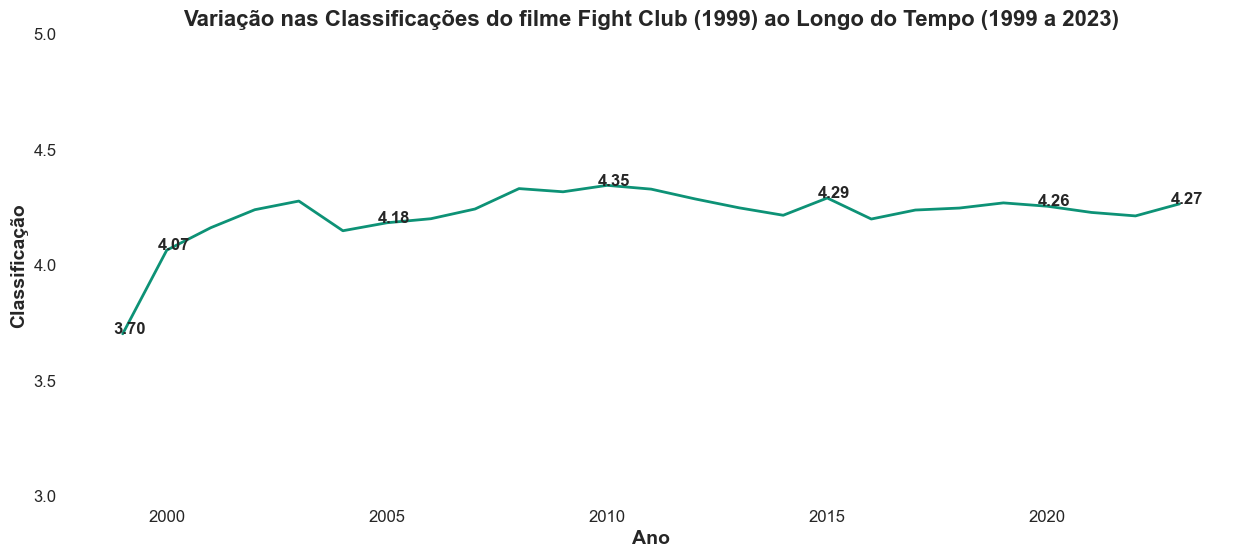

In [98]:
lineplot_rating_date_by_movieid(movieid=2959)

O filme **Central do Brasil** (1998) parece ter tido uma recepção inicial muito positiva em 1999, com uma média de 4.24, indicando um forte impacto emocional ou apreciação do público.

**Central do Brasil** é um filme brasileiro dirigido por Walter Salles, estrelado por Fernanda Montenegro e Vinícius de Oliveira. O filme é conhecido por sua narrativa emotiva e por abordar temas como a busca por identidade, conexões humanas e jornadas pessoais. Lançado em 1998, o filme foi indicado ao Oscar de Melhor Filme Estrangeiro e recebeu aclamação da crítica por suas performances, direção e narrativa poética.

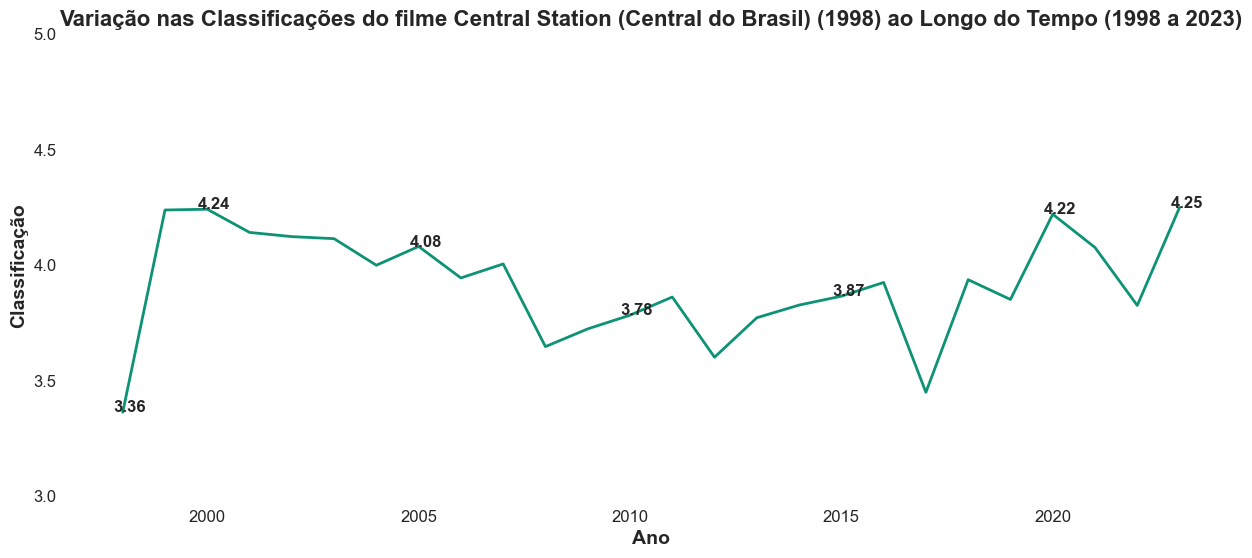

In [193]:
lineplot_rating_date_by_movieid(movieid=2357)

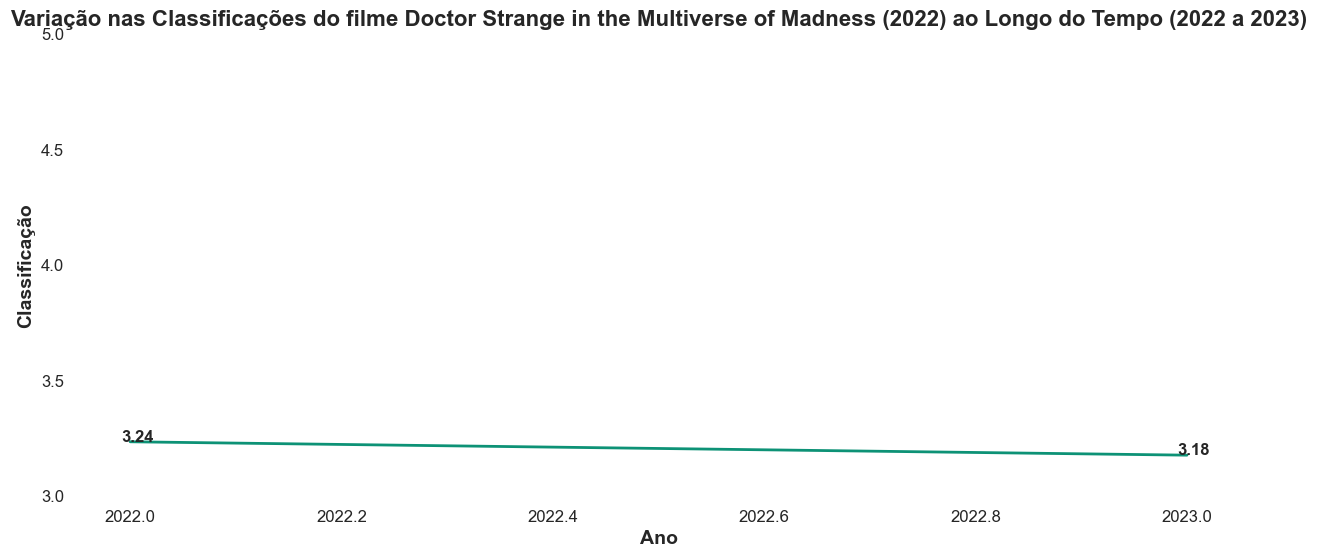

In [197]:
lineplot_rating_date_by_movieid(movieid=272525)